In [1]:
'''
Env: Python 3.9
An immediate global calcluation from Step 3 for scatter plot and ploynomial regression
Does Gloabl, all season

Input dir: /scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation
Output dir: /scratch/negishi/yan481/KenYan_Traffic_Model/Scatter_Plot_Global_New_DJF/


TODO: do global DJF season

'''

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from multiprocessing import Pool, cpu_count
import csv


def load_data(directory):
    years = [year for year in range(1979, 2017)]
    date_pattern = re.compile(r'_(\d{4}_\d{2}_\d{2})_')

    def fetch_files(prefix):
        files = sorted([f for f in os.listdir(directory) if f.startswith(prefix) and date_pattern.search(f)])
        # Filter only for DJF months
        return [f for f in files if date_pattern.search(f).group(1).split('_')[1] in ['01', '02', '12']]

    def average_files(files):
        avg_data = []
        for file_group in tqdm(files, desc="Processing"):
            dates = list(set(date_pattern.findall(file_group)))
            for date in dates:
                date_files = [f for f in files if date in f]
                avg_data.append(np.mean([np.load(os.path.join(directory, file)) for file in date_files], axis=0))
        return avg_data

    files = {
        "LWA": fetch_files("column_LWA"),
        "F1": fetch_files("F1_"),
        "F2": fetch_files("F2_"),
        "F3": fetch_files("F3_"),
    }

    return {key: average_files(val) for key, val in files.items()}


def convert_to_lat_lon(idx):
    x, y = idx
    
    lat = f"{x*1.5-90}°N" if x * 1.5 - 90 >= 0 else f"{90-x*1.5}°S"
        
    if y * 1.5 <= 180:
        lon = f"{y*1.5}°E"
    else:
        lon = f"{360 - y*1.5}°W"
        
    return lat, lon

def quadratic_regression(X, y):
    """
    Perform quadratic regression and return the model and the cross validation scores.
    """
    X = X.reshape(-1, 1)  # Reshape to be 2D
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)
    scores = cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')  # 5-fold CV
    mean_score = np.mean(scores)
    return model, mean_score

def max_flux_point(X, model):
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    predictions = model.predict(X_poly)
    idx_max = np.argmax(predictions)
    return X[idx_max], predictions[idx_max]

def save_regression_results(location, coefficients, error, max_flux_pt):
    equation = "y = " + " + ".join(f"{coef:.4f}x^{i}" for i, coef in enumerate(coefficients) if i > 0)
    with open('/scratch/negishi/yan481/KenYan_Traffic_Model/Scatter_Plot_Global_New_DJF/regression_results.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow([location, equation, error, max_flux_pt])

def plot_scatter(args):
    data, idx = args
    x_idx, y_idx = idx
    LWA_values = np.array([data["LWA"][i][x_idx, y_idx] for i in range(len(data["LWA"]))])
    F_total_values = np.array([data["F1"][i][x_idx, y_idx] + data["F2"][i][x_idx, y_idx] + data["F3"][i][x_idx, y_idx] for i in range(len(data["F1"]))])
    model, best_score = quadratic_regression(LWA_values, F_total_values)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(LWA_values.reshape(-1, 1))
    predictions = model.predict(X_poly)
    max_flux = max_flux_point(LWA_values, model)
    lat, lon = convert_to_lat_lon(idx)
    return lat, lon, LWA_values, F_total_values, predictions, model.coef_, best_score, max_flux

    
def parallel_plotting(idx):
    plot_scatter(data, idx)

if __name__ == "__main__":
    directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    data = load_data(directory)

    indices = [(data, (x, y)) for x in range(0, 121) for y in range(0, 240)]
    
    results = []
    for idx in tqdm(indices):
        results.append(plot_scatter(idx))

    with open('/scratch/negishi/yan481/KenYan_Traffic_Model/Scatter_Plot_Global_New_DJF/regression_results.csv', 'w') as file:
        writer = csv.writer(file)
        writer.writerow(["Location", "Best Fitting Curve", "Error", "Max Flux Point (LWA, Flux)"])
             
        for result in results:
            lat, lon, LWA_values, F_total_values, predictions, coefficients, best_score, max_flux = result
            plt.figure(figsize=(10,6))
            plt.scatter(LWA_values, F_total_values, color='blue', marker='D', alpha=0.4, label='F1+F2+F3 vs LWA')
            sorted_args = np.argsort(LWA_values)
            plt.plot(LWA_values[sorted_args], predictions[sorted_args], color='black', label='Quadratic Regression')
            plt.scatter(*max_flux, color='red', marker='o', label='Max Flux Point')
            plt.xlabel('LWA')
            plt.ylabel('Flux')
            plt.title(f'Total Flux vs Column Budget LWA at ({lat}, {lon}) - Max Flux: {max_flux}')
            plt.ylim(-1000, 2000)
            plt.xlim(0, 120)
            plt.grid(True)
            plt.legend()
            output_path = f"/scratch/negishi/yan481/KenYan_Traffic_Model/Scatter_Plot_Global_New_DJF/plot_{lat}_{lon}.png"
            plt.savefig(output_path)
            plt.close()
            
            equation = "y = " + " + ".join(f"{coef:.4f}x^{i}" for i, coef in enumerate(coefficients) if i > 0)
            location = f"({lat}, {lon})"
            writer.writerow([location, equation, best_score, max_flux])
            
    print("DJF Scatter plotting and regression analysis completed!")


100%|██████████| 29040/29040 [09:04<00:00, 53.32it/s]


DJF Scatter plotting and regression analysis completed!


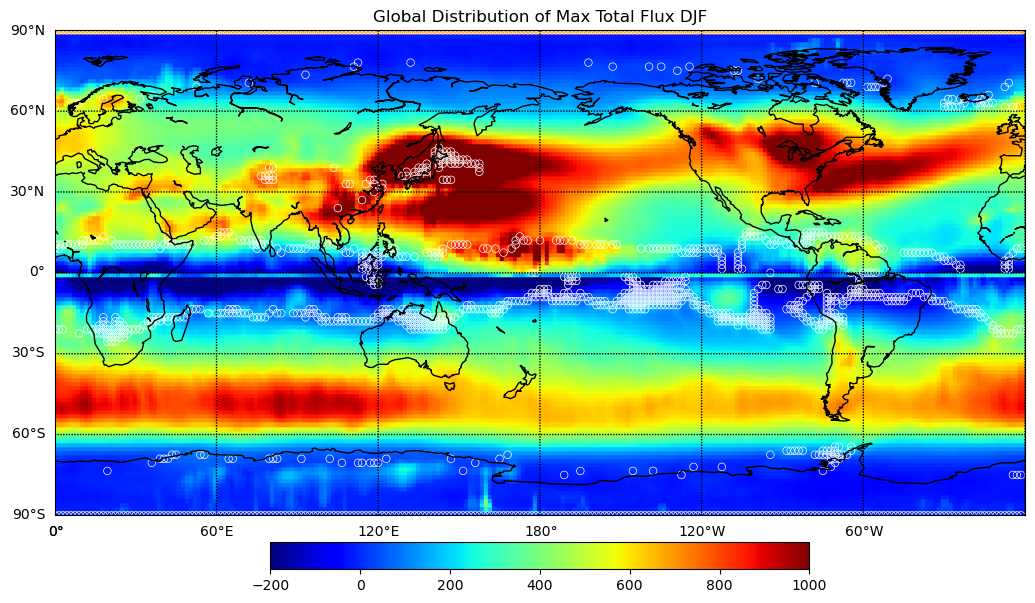

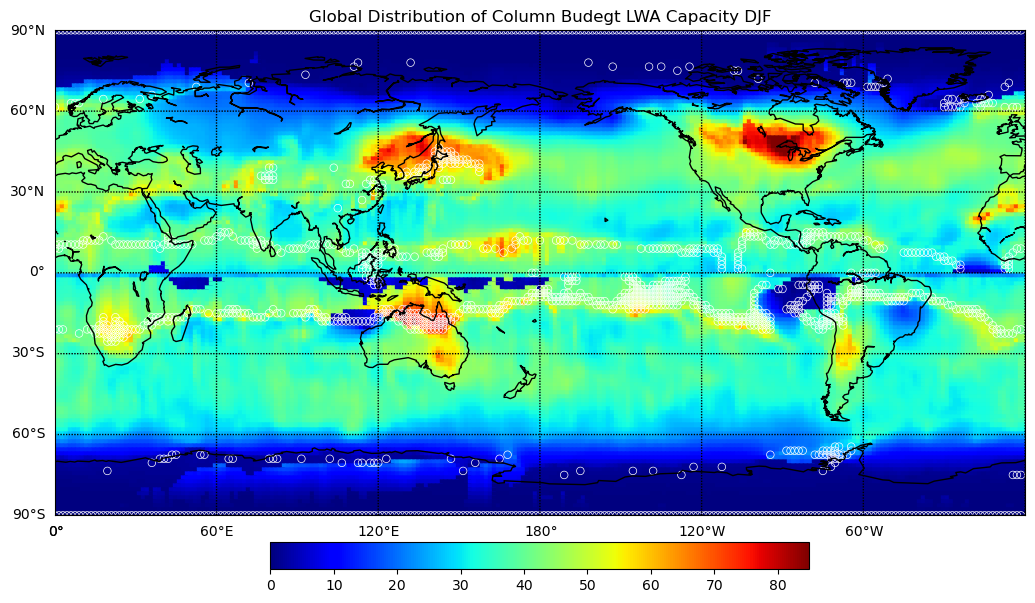

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load CSV data
data = pd.read_csv("/scratch/negishi/yan481/KenYan_Traffic_Model/Scatter_Plot_Global_New_DJF/regression_results.csv")

# Extract the necessary columns
def extract_lat(loc):
    lat_str = loc.split(",")[0].replace("(", "").strip()
    if "°S" in lat_str:
        return -float(lat_str.replace("°S", ""))
    else:
        return float(lat_str.replace("°N", ""))

def extract_lon(loc):
    lon_str = loc.split(",")[1].replace(")", "").strip()
    if "°W" in lon_str:
        return 360.0 - float(lon_str.replace("°W", ""))
    else:
        return float(lon_str.replace("°E", ""))
    

data['Lat'] = data['Location'].apply(extract_lat)
data['Lon'] = data['Location'].apply(extract_lon)


data['x2_coefficient'] = data['Best Fitting Curve'].apply(lambda equation: float(equation.split(" + ")[1].split("x^2")[0]))
data['Max_Flux'] = data['Max Flux Point (LWA, Flux)'].apply(lambda point: float(point.split(",")[1].replace(")", "")))
data['Correspondent_LWA'] = data['Max Flux Point (LWA, Flux)'].apply(lambda point: float(point.split(",")[0].replace("(", "")))


# Function to plot heatmap with contours for regions where the coefficient of x^2 term is <0.05
def plot_heatmap(values, title, vmin, vmax):
    plt.figure(figsize=(15, 7))
    m = Basemap(projection='cyl', llcrnrlon=0, llcrnrlat=-90, urcrnrlon=360, urcrnrlat=90)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90,91,30), labels=[1,0,0,0])
    m.drawmeridians(np.arange(0,361,60), labels=[0,0,0,1])
    xi, yi = m(data['Lon'].values, data['Lat'].values)
    cs = m.scatter(xi, yi, c=values, cmap="jet", marker="s", s=20, vmin=vmin, vmax=vmax)
  
    # Highlight regions where the absolute value of the coefficient for the x^2 term is less than 0.05
    mask = np.abs(data['x2_coefficient']) < 0.05
    xi_mask, yi_mask = m(data['Lon'][mask].values, data['Lat'][mask].values)
    m.scatter(xi_mask, yi_mask, c='none', edgecolor='white', linewidth=0.5, s=30)
    
    plt.colorbar(cs, orientation='horizontal', fraction=0.05, pad=0.05)
    plt.title(title)
    output_path = f"/scratch/negishi/yan481/KenYan_Traffic_Model/Scatter_Plot_Global_New_DJF/{title}.png"
    plt.savefig(output_path)
    plt.show()

# Create the heatmaps
plot_heatmap(data['Max_Flux'].values, "Global Distribution of Max Total Flux DJF", -200, 1000)
plot_heatmap(data['Correspondent_LWA'].values, "Global Distribution of Column Budegt LWA Capacity DJF", 0, 85)

# Reshape the arrays to 2D format (121x240)
flux_capacity_2d = data['Max_Flux'].values.reshape(121, 240)
lwa_capacity_2d = data['Correspondent_LWA'].values.reshape(121, 240)

# Save the 2D arrays as .npy files
np.save("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy", flux_capacity_2d)
np.save("/scratch/negishi/yan481/KenYan_Traffic_Model/LWA_Capacity_DJF.npy", lwa_capacity_2d)





In [3]:
import numpy as np
import datetime

# Load the data
data1 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0.npy', allow_pickle=True)
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0SH.npy', allow_pickle=True)

# Vertically stack the arrays
data = np.vstack((data1, data2))


# Print the shape and data type of the array
print(f"Shape of the array: {data.shape}")
print(f"Data type of the array: {data.dtype}")

# Print first few rows (let's say 5) for a sample
print(data[:5])


# Extract the duration, longitude, and latitude values from the strings
durations = [int(row[1].split(":")[1].strip()) for row in data]
longitudes = [int(row[2].split(":")[1].strip()) for row in data]
latitudes = [int(row[3].split(":")[1].strip()) for row in data]

# Convert the lists to numpy arrays
durations = np.array(durations)
longitudes = np.array(longitudes)
latitudes = np.array(latitudes)

# Print statistics
print(f"Duration - Mean: {np.mean(durations)}, Min: {np.min(durations)}, Max: {np.max(durations)}, Std: {np.std(durations)}")
print(f"Longitude - Mean: {np.mean(longitudes)}, Min: {np.min(longitudes)}, Max: {np.max(longitudes)}, Std: {np.std(longitudes)}")
print(f"Latitude - Mean: {np.mean(latitudes)}, Min: {np.min(latitudes)}, Max: {np.max(latitudes)}, Std: {np.std(latitudes)}")

# Check if there are any events not at 0 hour and 0 minute
non_zero_time_events = [row for row in data if isinstance(row[0], datetime.datetime) and (row[0].hour != 0 or row[0].minute != 0)]

# Print the count of such events and a few examples
print(f"Number of non-zero time events: {len(non_zero_time_events)}")
print("Examples of non-zero time events:")
for event in non_zero_time_events[:5]:  # Print first 5 examples
    print(event)

Shape of the array: (2177, 4)
Data type of the array: object
[[datetime.datetime(1959, 3, 3, 0, 0) 'duration: 8' 'Lon: 128' 'Lat: 78']
 [datetime.datetime(1959, 3, 5, 0, 0) 'duration: 6' 'Lon: 333' 'Lat: 53']
 [datetime.datetime(1959, 4, 27, 0, 0) 'duration: 10' 'Lon: 7' 'Lat: 59']
 [datetime.datetime(1959, 5, 5, 0, 0) 'duration: 7' 'Lon: 199' 'Lat: 47']
 [datetime.datetime(1959, 5, 6, 0, 0) 'duration: 7' 'Lon: 74' 'Lat: 86']]
Duration - Mean: 6.539274230592558, Min: 5, Max: 23, Std: 1.9737473194580097
Longitude - Mean: 198.73357831878732, Min: 0, Max: 359, Std: 97.80671807127378
Latitude - Mean: 26.861736334405144, Min: -87, Max: 87, Std: 49.41602650955409
Number of non-zero time events: 0
Examples of non-zero time events:


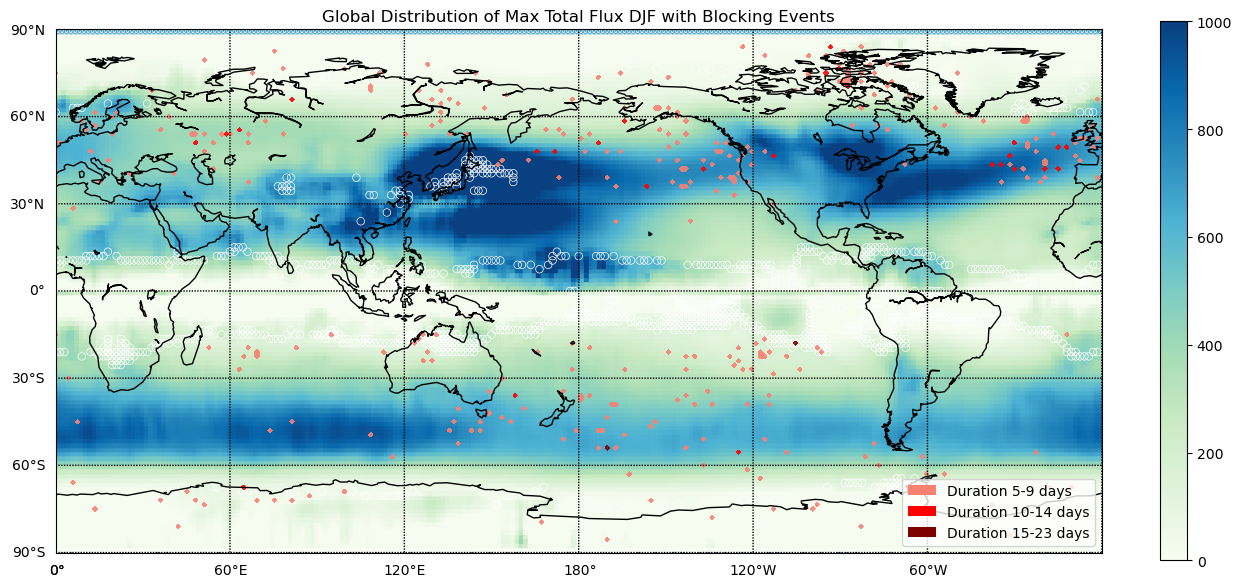

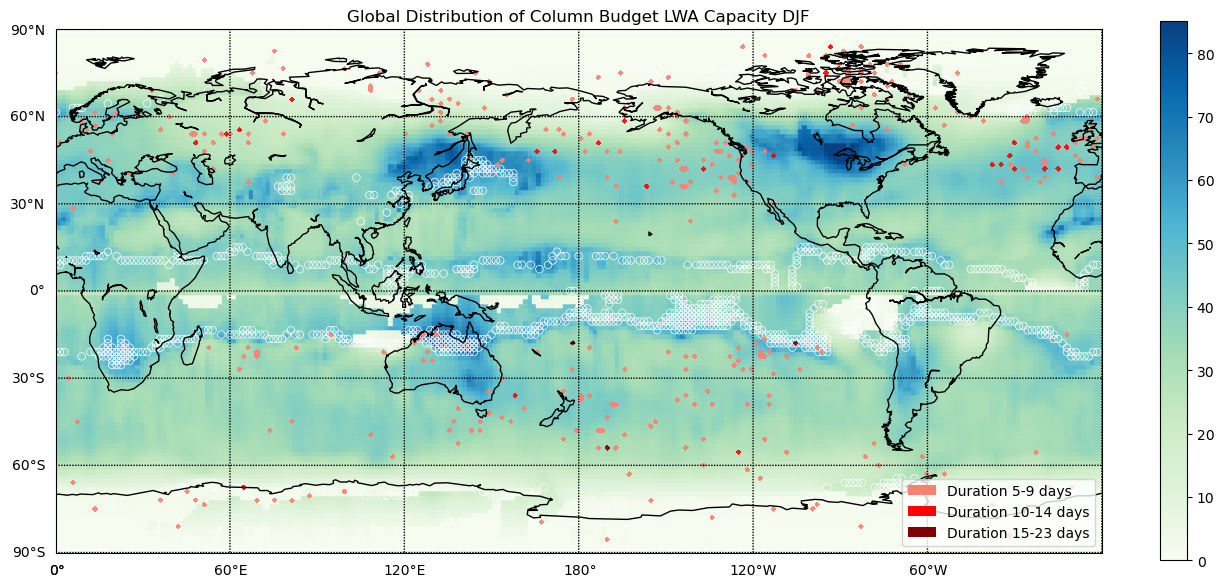

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch

# Load CSV data
data = pd.read_csv("/scratch/negishi/yan481/KenYan_Traffic_Model/Scatter_Plot_Global_New_DJF/regression_results.csv")

# Extract the necessary columns
def extract_lat(loc):
    lat_str = loc.split(",")[0].replace("(", "").strip()
    if "°S" in lat_str:
        return -float(lat_str.replace("°S", ""))
    else:
        return float(lat_str.replace("°N", ""))

def extract_lon(loc):
    lon_str = loc.split(",")[1].replace(")", "").strip()
    if "°W" in lon_str:
        return 360.0 - float(lon_str.replace("°W", ""))
    else:
        return float(lon_str.replace("°E", ""))
    

data['Lat'] = data['Location'].apply(extract_lat)
data['Lon'] = data['Location'].apply(extract_lon)


data['x2_coefficient'] = data['Best Fitting Curve'].apply(lambda equation: float(equation.split(" + ")[1].split("x^2")[0]))
data['Max_Flux'] = data['Max Flux Point (LWA, Flux)'].apply(lambda point: float(point.split(",")[1].replace(")", "")))
data['Correspondent_LWA'] = data['Max Flux Point (LWA, Flux)'].apply(lambda point: float(point.split(",")[0].replace("(", "")))

# Load blocking events
data1 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0NH.npy', allow_pickle=True)
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0SH.npy', allow_pickle=True)

# Vertically stack the arrays
blocking_data = np.vstack((data1, data2))

# Filter rows based on the month and year condition
filtered_blocking_data = []
for event in blocking_data:
    event_date = event[0]
    if event_date.month in [1, 2, 12] and 1979 <= event_date.year <= 2016:
        filtered_blocking_data.append(event)

# Convert the filtered list back to a NumPy array
blocking_data = np.array(filtered_blocking_data)

# # Filter rows based on the month condition
# blocking_data = blocking_data[np.isin([dt.month for dt in blocking_data[:, 0]], [1, 2, 12])]

longitudes = [int(row[2].split(":")[1].strip()) for row in blocking_data]
latitudes = [int(row[3].split(":")[1].strip()) for row in blocking_data]

# Get durations from blocking data
durations = [int(row[1].split(":")[1].strip()) for row in blocking_data]

# Create different grids for different duration ranges
blocking_grid_5_9 = np.zeros((121, 240))
blocking_grid_10_14 = np.zeros((121, 240))
blocking_grid_15_23 = np.zeros((121, 240))

for lon, lat, duration in zip(longitudes, latitudes, durations):
    if 5 <= duration <= 9:
        blocking_grid_5_9[int((lat + 90) * 120 / 180), int(lon * 240 / 360)] = 1
    elif 10 <= duration <= 14:
        blocking_grid_10_14[int((lat + 90) * 120 / 180), int(lon * 240 / 360)] = 1
    elif 15 <= duration <= 23:
        blocking_grid_15_23[int((lat + 90) * 120 / 180), int(lon * 240 / 360)] = 1

# Function to plot heatmap with contours for regions where the coefficient of x^2 term is <0.05
def plot_heatmap(values, title, vmin, vmax):
    plt.figure(figsize=(15, 7))
    m = Basemap(projection='cyl', llcrnrlon=0, llcrnrlat=-90, urcrnrlon=360, urcrnrlat=90)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90,91,30), labels=[1,0,0,0])
    m.drawmeridians(np.arange(0,361,60), labels=[0,0,0,1])
    xi, yi = m(data['Lon'].values, data['Lat'].values)
    cs = m.scatter(xi, yi, c=values, cmap="GnBu", marker="s", s=20, vmin=vmin, vmax=vmax)
  
    # Highlight regions where the absolute value of the coefficient for the x^2 term is less than 0.05
    mask = np.abs(data['x2_coefficient']) < 0.05
    xi_mask, yi_mask = m(data['Lon'][mask].values, data['Lat'][mask].values)
    m.scatter(xi_mask, yi_mask, c='none', edgecolor='white', linewidth=0.5, s=30)
    
    # Plot different blocking grids with different colors
    lon, lat = np.meshgrid(np.linspace(0, 360, 240), np.linspace(-90, 90, 121))
    x, y = m(lon, lat)
    
    # Define colors for different duration ranges
    color_5_9 = 'salmon'
    color_10_14 = 'red'
    color_15_23 = 'maroon'

    m.contourf(x, y, blocking_grid_5_9, levels=[0.5, 1.5], colors=[color_5_9], alpha=0.9)
    m.contourf(x, y, blocking_grid_10_14, levels=[0.5, 1.5], colors=[color_10_14], alpha=0.9)
    m.contourf(x, y, blocking_grid_15_23, levels=[0.5, 1.5], colors=[color_15_23], alpha=0.9)
    # Create a custom legend for the colored blocking events
    legend_elements = [Patch(facecolor=color_5_9, label='Duration 5-9 days'),
                       Patch(facecolor=color_10_14, label='Duration 10-14 days'),
                       Patch(facecolor=color_15_23, label='Duration 15-23 days')]
    
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.colorbar(cs, fraction=0.05, pad=0.05)
    plt.title(title)
    plt.show()

# Plotting the heatmap
plot_heatmap(data['Max_Flux'].values, "Global Distribution of Max Total Flux DJF with Blocking Events", 0, 1000)
plot_heatmap(data['Correspondent_LWA'].values, "Global Distribution of Column Budget LWA Capacity DJF", 0, 85)



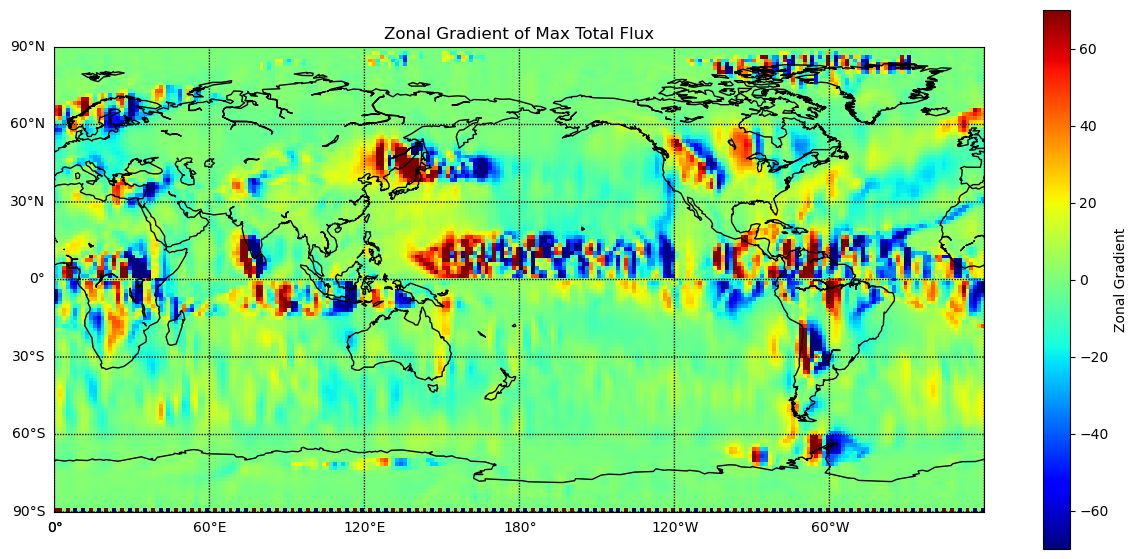

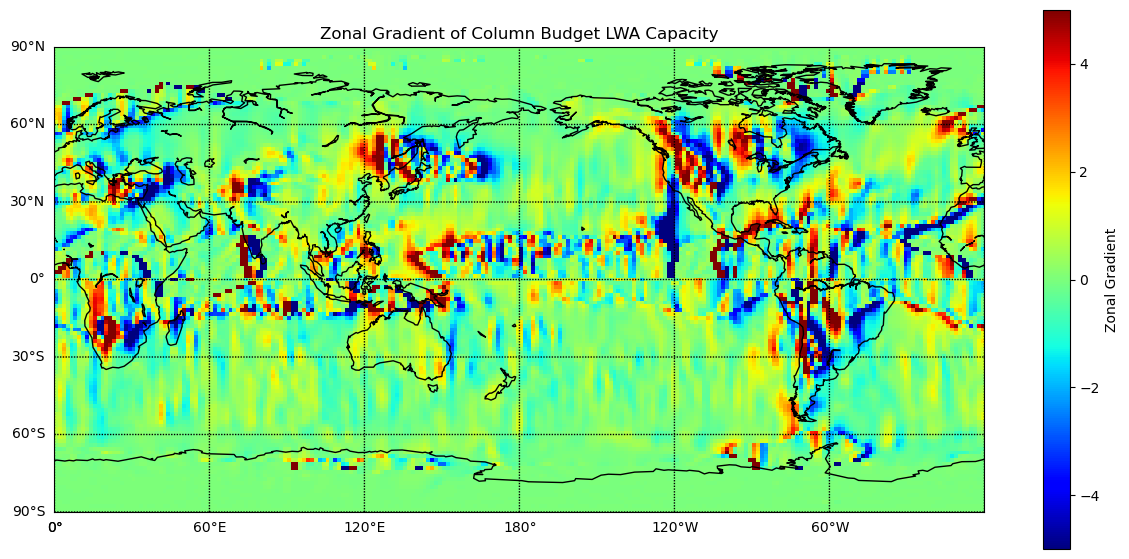

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load the data from the .npy files
flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity.npy")
lwa_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/LWA_Capacity.npy")

# Calculate the zonal gradients
flux_zonal_gradient = np.gradient(flux_capacity_2d, axis=1)
lwa_zonal_gradient = np.gradient(lwa_capacity_2d, axis=1)

# Calculate 5% and 95% quantiles for both datasets
flux_vmin, flux_vmax = np.percentile(flux_zonal_gradient, [5, 95])
lwa_vmin, lwa_vmax = np.percentile(lwa_zonal_gradient, [5, 95])

def plot_gradient(data, title, vmin, vmax):
    plt.figure(figsize=(15, 7))
    m = Basemap(projection='cyl', llcrnrlon=0, llcrnrlat=-90, urcrnrlon=360, urcrnrlat=90)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90,91,30), labels=[1,0,0,0])
    m.drawmeridians(np.arange(0,361,60), labels=[0,0,0,1])
    
    lon, lat = np.meshgrid(np.linspace(0, 360, 240), np.linspace(-90, 90, 121))
    x, y = m(lon, lat)
    
    im = m.imshow(data, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Zonal Gradient')
    plt.title(title)
    plt.show()

# Plot the zonal gradients with given vmin and vmax
# plot_gradient(flux_zonal_gradient, "Zonal Gradient of Max Total Flux", flux_vmin, flux_vmax)
plot_gradient(flux_zonal_gradient, "Zonal Gradient of Max Total Flux", -70, 70)
# plot_gradient(lwa_zonal_gradient, "Zonal Gradient of Column Budget LWA Capacity", lwa_vmin, lwa_vmax)
plot_gradient(lwa_zonal_gradient, "Zonal Gradient of Column Budget LWA Capacity", -5, 5)

# Save the zonal gradient data as 2D .npy files
np.save("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Zonal_Gradient.npy", flux_zonal_gradient)
np.save("/scratch/negishi/yan481/KenYan_Traffic_Model/LWA_Zonal_Gradient.npy", lwa_zonal_gradient)


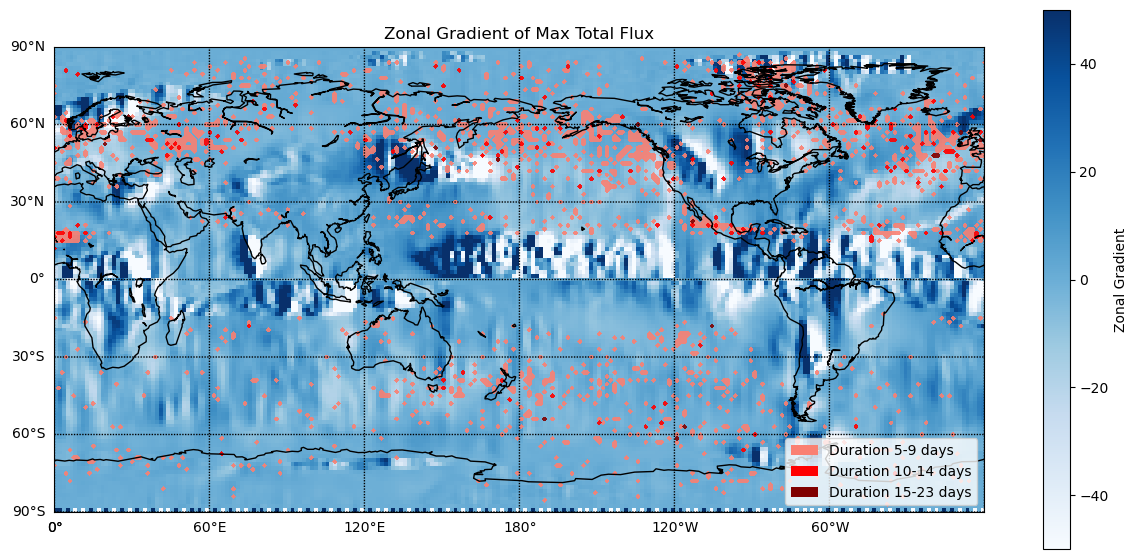

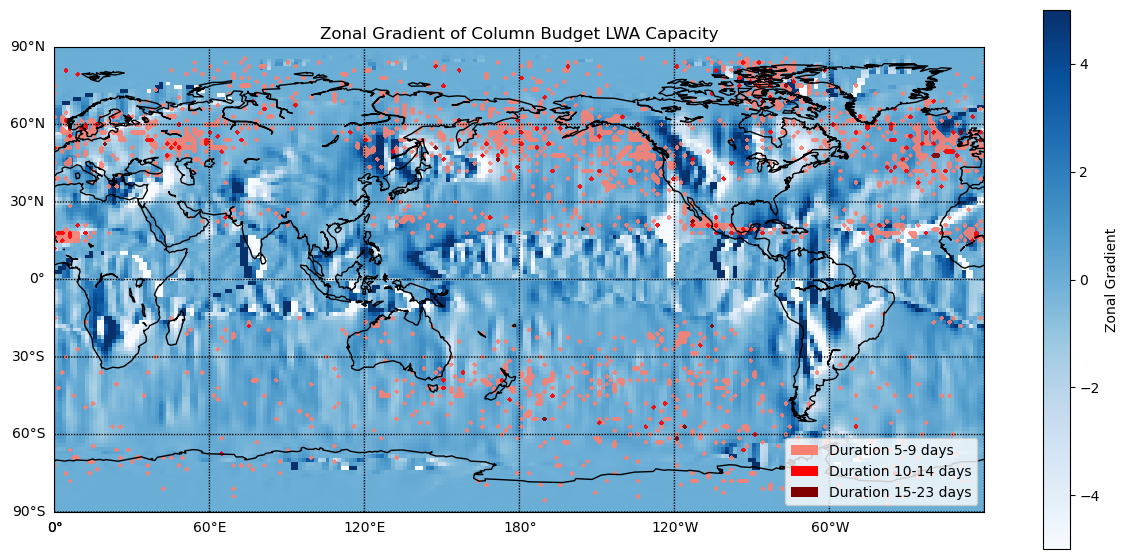

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch

# Load blocking events
data1 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0NH.npy', allow_pickle=True)
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0SH.npy', allow_pickle=True)

# Vertically stack the arrays
blocking_data = np.vstack((data1, data2))

longitudes = [int(row[2].split(":")[1].strip()) for row in blocking_data]
latitudes = [int(row[3].split(":")[1].strip()) for row in blocking_data]
durations = [int(row[1].split(":")[1].strip()) for row in blocking_data]

# Load the data from the .npy files
flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity.npy")
lwa_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/LWA_Capacity.npy")

# Calculate the zonal gradients
flux_zonal_gradient = np.gradient(flux_capacity_2d, axis=1)
lwa_zonal_gradient = np.gradient(lwa_capacity_2d, axis=1)

# Calculate 5% and 95% quantiles for both datasets
flux_vmin, flux_vmax = np.percentile(flux_zonal_gradient, [5, 95])
lwa_vmin, lwa_vmax = np.percentile(lwa_zonal_gradient, [5, 95])

def plot_gradient(data, title, vmin, vmax):
    plt.figure(figsize=(15, 7))
    m = Basemap(projection='cyl', llcrnrlon=0, llcrnrlat=-90, urcrnrlon=360, urcrnrlat=90)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90,91,30), labels=[1,0,0,0])
    m.drawmeridians(np.arange(0,361,60), labels=[0,0,0,1])
    
    lon, lat = np.meshgrid(np.linspace(0, 360, 240), np.linspace(-90, 90, 121))
    x, y = m(lon, lat)
    
    im = m.imshow(data, cmap='Blues', origin='lower', vmin=vmin, vmax=vmax)
    
    # Define colors for different duration ranges
    color_5_9 = 'salmon'
    color_10_14 = 'red'
    color_15_23 = 'maroon'
    
    m.contourf(x, y, blocking_grid_5_9, levels=[0.5, 1.5], colors=[color_5_9], alpha=0.9)
    m.contourf(x, y, blocking_grid_10_14, levels=[0.5, 1.5], colors=[color_10_14], alpha=0.9)
    m.contourf(x, y, blocking_grid_15_23, levels=[0.5, 1.5], colors=[color_15_23], alpha=0.9)
    # Create a custom legend for the colored blocking events
    legend_elements = [Patch(facecolor=color_5_9, label='Duration 5-9 days'),
                       Patch(facecolor=color_10_14, label='Duration 10-14 days'),
                       Patch(facecolor=color_15_23, label='Duration 15-23 days')]
    
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.colorbar(im, label='Zonal Gradient')
    plt.title(title)
    plt.show()

# Plot the zonal gradients with given vmin and vmax
plot_gradient(flux_zonal_gradient, "Zonal Gradient of Max Total Flux", -50, 50)
plot_gradient(lwa_zonal_gradient, "Zonal Gradient of Column Budget LWA Capacity", -5, 5)


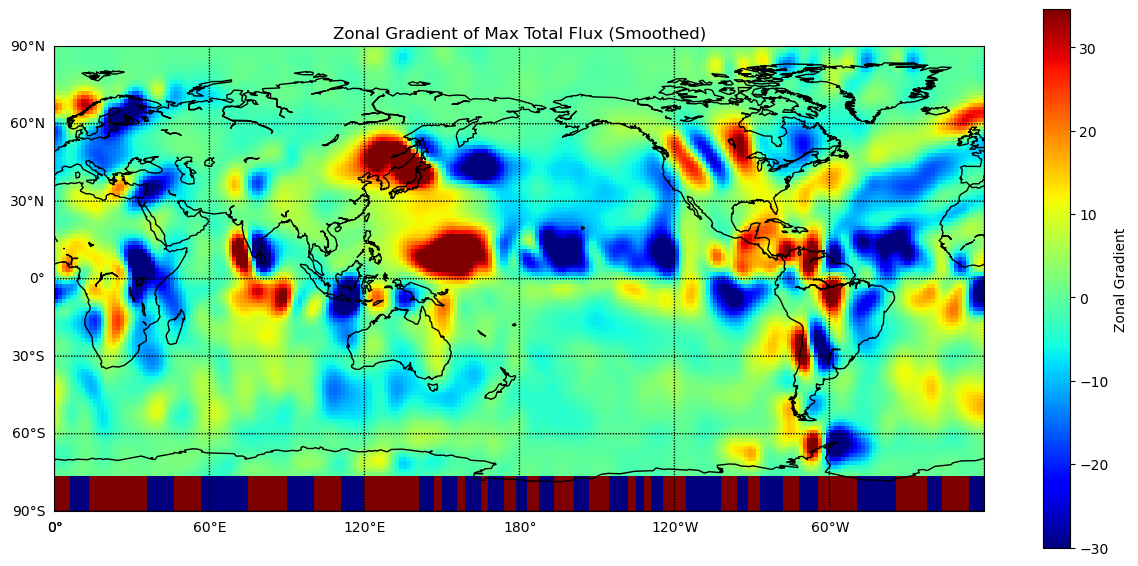

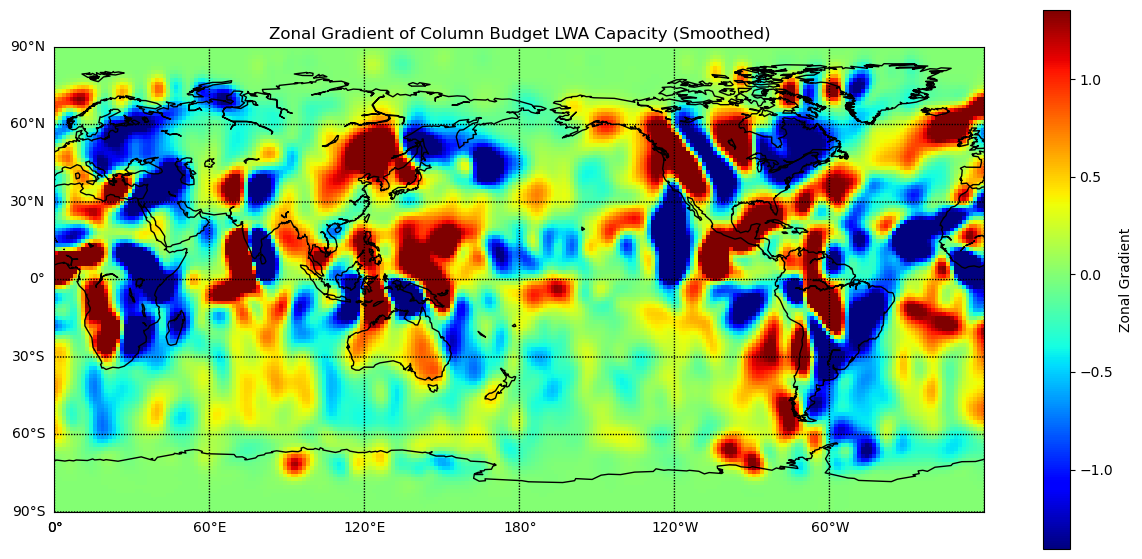

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.ndimage import gaussian_filter

# Load the data from the .npy files
flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity.npy")
lwa_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/LWA_Capacity.npy")

# Calculate the zonal gradients
flux_zonal_gradient = np.gradient(flux_capacity_2d, axis=1)
lwa_zonal_gradient = np.gradient(lwa_capacity_2d, axis=1)

# Apply Gaussian filter
sigma = 2  # Standard deviation for Gaussian kernel
flux_zonal_gradient_smoothed = gaussian_filter(flux_zonal_gradient, sigma=sigma)
lwa_zonal_gradient_smoothed = gaussian_filter(lwa_zonal_gradient, sigma=sigma)

# Calculate 5% and 95% quantiles for both datasets
flux_vmin, flux_vmax = np.percentile(flux_zonal_gradient_smoothed, [5, 95])
lwa_vmin, lwa_vmax = np.percentile(lwa_zonal_gradient_smoothed, [5, 95])

def plot_gradient(data, title, vmin, vmax):
    plt.figure(figsize=(15, 7))
    m = Basemap(projection='cyl', llcrnrlon=0, llcrnrlat=-90, urcrnrlon=360, urcrnrlat=90)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90,91,30), labels=[1,0,0,0])
    m.drawmeridians(np.arange(0,361,60), labels=[0,0,0,1])
    
    lon, lat = np.meshgrid(np.linspace(0, 360, 240), np.linspace(-90, 90, 121))
    x, y = m(lon, lat)
    
    im = m.imshow(data, cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar(im, label='Zonal Gradient')
    plt.title(title)
    plt.show()

# Plot the smoothed zonal gradients with given vmin and vmax
plot_gradient(flux_zonal_gradient_smoothed, "Zonal Gradient of Max Total Flux (Smoothed)", flux_vmin, flux_vmax)
plot_gradient(lwa_zonal_gradient_smoothed, "Zonal Gradient of Column Budget LWA Capacity (Smoothed)", lwa_vmin, lwa_vmax)

# Save the smoothed zonal gradient data as 2D .npy files
np.save("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Zonal_Gradient_Smoothed.npy", flux_zonal_gradient_smoothed)
np.save("/scratch/negishi/yan481/KenYan_Traffic_Model/LWA_Zonal_Gradient_Smoothed.npy", lwa_zonal_gradient_smoothed)


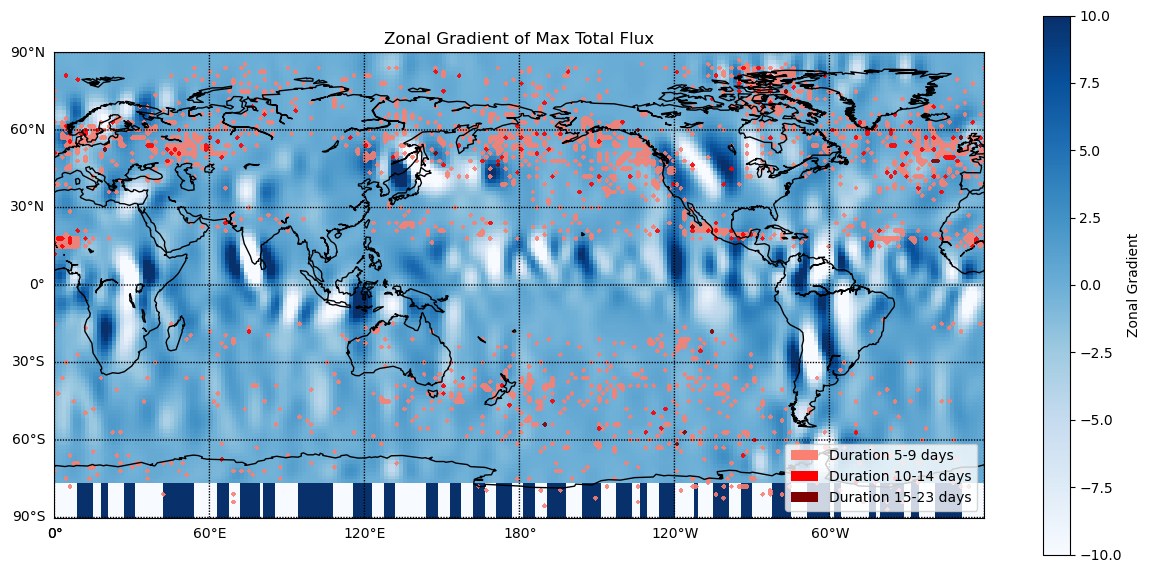

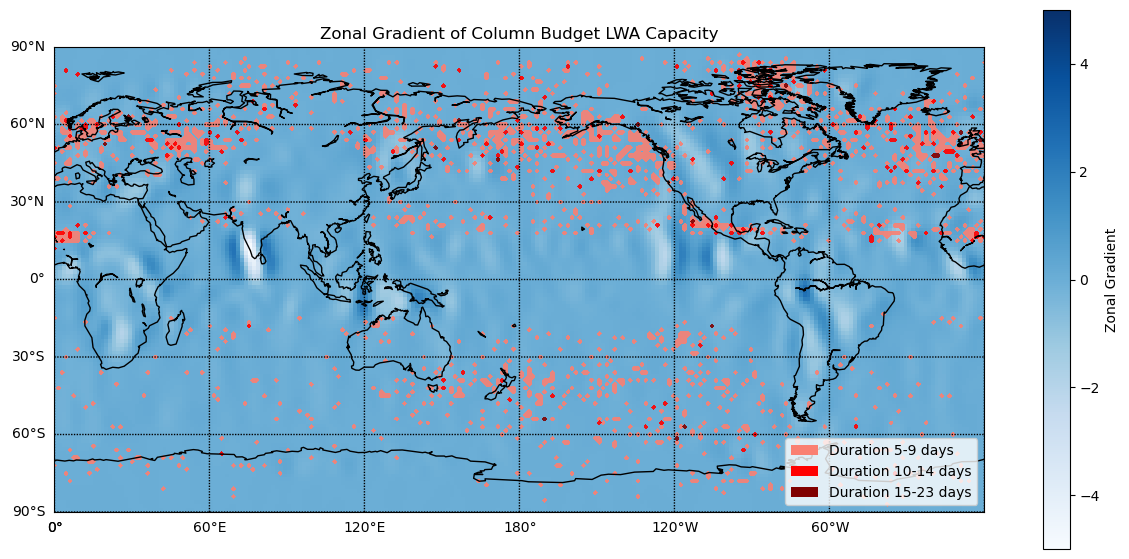

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch

# Load blocking events
data1 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0NH.npy', allow_pickle=True)
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0SH.npy', allow_pickle=True)

# Vertically stack the arrays
blocking_data = np.vstack((data1, data2))

longitudes = [int(row[2].split(":")[1].strip()) for row in blocking_data]
latitudes = [int(row[3].split(":")[1].strip()) for row in blocking_data]
durations = [int(row[1].split(":")[1].strip()) for row in blocking_data]

# Create different grids for different duration ranges
blocking_grid_5_9 = np.zeros((121, 240))
blocking_grid_10_14 = np.zeros((121, 240))
blocking_grid_15_23 = np.zeros((121, 240))

for lon, lat, duration in zip(longitudes, latitudes, durations):
    if 5 <= duration <= 9:
        blocking_grid_5_9[int((lat + 90) * 120 / 180), int(lon * 240 / 360)] = 1
    elif 10 <= duration <= 14:
        blocking_grid_10_14[int((lat + 90) * 120 / 180), int(lon * 240 / 360)] = 1
    elif 15 <= duration <= 23:
        blocking_grid_15_23[int((lat + 90) * 120 / 180), int(lon * 240 / 360)] = 1

# Load the data from the .npy files
flux_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Zonal_Gradient_Smoothed.npy")
lwa_capacity_2d = np.load("/scratch/negishi/yan481/KenYan_Traffic_Model/LWA_Zonal_Gradient_Smoothed.npy")

# Calculate the zonal gradients
flux_zonal_gradient = np.gradient(flux_capacity_2d, axis=1)
lwa_zonal_gradient = np.gradient(lwa_capacity_2d, axis=1)

# Calculate 5% and 95% quantiles for both datasets
flux_vmin, flux_vmax = np.percentile(flux_zonal_gradient, [5, 95])
lwa_vmin, lwa_vmax = np.percentile(lwa_zonal_gradient, [5, 95])

def plot_gradient(data, title, vmin, vmax):
    plt.figure(figsize=(15, 7))
    m = Basemap(projection='cyl', llcrnrlon=0, llcrnrlat=-90, urcrnrlon=360, urcrnrlat=90)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90,91,30), labels=[1,0,0,0])
    m.drawmeridians(np.arange(0,361,60), labels=[0,0,0,1])
    
    lon, lat = np.meshgrid(np.linspace(0, 360, 240), np.linspace(-90, 90, 121))
    x, y = m(lon, lat)
    
    im = m.imshow(data, cmap='Blues', origin='lower', vmin=vmin, vmax=vmax)
    
    # Define colors for different duration ranges
    color_5_9 = 'salmon'
    color_10_14 = 'red'
    color_15_23 = 'maroon'
    
    m.contourf(x, y, blocking_grid_5_9, levels=[0.5, 1.5], colors=[color_5_9], alpha=0.9)
    m.contourf(x, y, blocking_grid_10_14, levels=[0.5, 1.5], colors=[color_10_14], alpha=0.9)
    m.contourf(x, y, blocking_grid_15_23, levels=[0.5, 1.5], colors=[color_15_23], alpha=0.9)
    # Create a custom legend for the colored blocking events
    legend_elements = [Patch(facecolor=color_5_9, label='Duration 5-9 days'),
                       Patch(facecolor=color_10_14, label='Duration 10-14 days'),
                       Patch(facecolor=color_15_23, label='Duration 15-23 days')]
    
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.colorbar(im, label='Zonal Gradient')
    plt.title(title)
    plt.show()

# Plot the zonal gradients with given vmin and vmax
plot_gradient(flux_zonal_gradient, "Zonal Gradient of Max Total Flux", -10, 10)
plot_gradient(lwa_zonal_gradient, "Zonal Gradient of Column Budget LWA Capacity", -5, 5)


/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axi

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, 

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axi

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, d

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axi

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.typ

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processing:   0%|          | 0/13606 [00:00<?, ?it/s]/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yan481/.local/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processing: 100%|██████████| 13606/13606 [00:03<00:00, 4037.82it/s]


TypeError: Invalid shape (1,) for image data

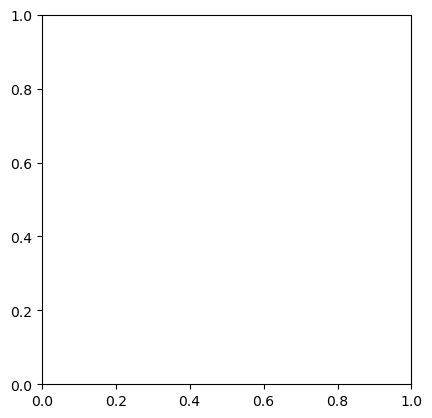

In [2]:
import os
import re
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt

def fetch_files(directory, prefix):
    date_pattern = re.compile(r'_(\d{4}_\d{2}_\d{2})_')
    files = sorted([f for f in os.listdir(directory) if f.startswith(prefix) and date_pattern.search(f)])
    return [f for f in files if date_pattern.search(f).group(1).split('_')[1] in ['01', '02', '12']]

def process_file_group(file_group):
    date_pattern = re.compile(r'_(\d{4}_\d{2}_\d{2})_')
    dates = list(set(date_pattern.findall(file_group)))
    directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    avg_data = []
    for date in dates:
        date_files = [f for f in file_group if date in f]
        avg_data.append(np.mean([np.load(os.path.join(directory, file)) for file in date_files], axis=0))
    return avg_data

def average_files(files):
    with ProcessPoolExecutor() as executor:
        avg_data = list(tqdm(executor.map(process_file_group, files), desc="Processing", total=len(files)))
    return avg_data

def load_data(directory):
    files = {
        "LWA": fetch_files(directory, "column_LWA"),
        "F1": fetch_files(directory, "F1_"),
        "F2": fetch_files(directory, "F2_"),
        "F3": fetch_files(directory, "F3_"),
    }
    return {key: average_files(val) for key, val in files.items()}

def plot_heatmap(data, title):
    plt.imshow(data, origin='lower', cmap='jet')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

def main():
    directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    data = load_data(directory)
    
    F1_mean = np.mean(data['F1'], axis=0)
    F2_mean = np.mean(data['F2'], axis=0)
    F3_mean = np.mean(data['F3'], axis=0)
    
    DJF_Re_analysis_mean = F1_mean + F2_mean + F3_mean
    np.save('DJF_Reanalysis_mean.npy', DJF_Re_analysis_mean)
    plot_heatmap(DJF_Re_analysis_mean, 'DJF Re-analysis Mean')

main()
